In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols

In [3]:
'''
Example of file in the directory:
Task Order: [2, 1, 3]
Terrain Order: [R1, L1, R2, L1, L2, R2, L1, L2, R1]
Task Results: [2, -23, -24, 5, 0, 0, 4, 1, 3]

True Odd Ones:      [L, R, R]
Chosen Odd Ones:    [L, L, L]
Sureness:           [0.7, 1, 0.7]
Enjoyment:          [0.89, 0.41, 0.72, 0.8, 0.89, 0.91, 0.73, 0.96, 0.58]
Difficulty:         [0, 0.37, 0, 0.16, 0.38, 0.45, 0.59, 0.67, 0.55]

Total Enjoyment: 5
How Often: Daily
Genre(s): Adventure;Action;RPG;Casual;Sandbox;Simulation;Party;
Gender: M
Platform: PC
Ability: Experienced but Inactive
'''

class Participant:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [4]:
def parse_file(file_path):
    """Parse a single file to create a Participant object."""
    with open(file_path, 'r') as file:
        data = {}
        for line in file:
            line = line.strip()  # Remove extra spaces/newlines
            if not line:  # Skip empty lines
                continue
            if ':' not in line:  # Skip lines without a colon
                continue

            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip()
            
            if key in ["Task Order", "Task Results", "True Odd Ones", 
                       "Chosen Odd Ones", "Sureness", "Enjoyment", "Difficulty"]:
                # Try to handle numeric values by parsing them as floats
                try:
                    data[key.lower().replace(' ', '_')] = list(map(float, value.strip('[]').split(',')))
                except ValueError:
                    # If a ValueError occurs (non-numeric value), split the string values directly
                    data[key.lower().replace(' ', '_')] = [item.strip() for item in value.strip('[]').split(',')]
            
            elif key == "Terrain Order":
                # Split and strip values to handle items like R1, L1, etc.
                data[key.lower().replace(' ', '_')] = [item.strip() for item in value.strip('[]').split(',')]
            
            elif key in ["Total Enjoyment"]:
                data[key.lower().replace(' ', '_')] = float(value)  # Convert to a float if needed
            
            elif key in ["How Often", "Gender", "Platform", "Ability"]:
                data[key.lower().replace(' ', '_')] = value
            
            elif key == "Genre(s)":
                data['genres'] = value.split(';')[:-1]  # Remove trailing empty value
            
        # Infer participant_id from filename
        data['participant_id'] = os.path.splitext(os.path.basename(file_path))[0]
    return Participant(**data)

In [5]:
def load_participants(directory):
    """Load all participants from a directory."""
    participants = {}
    files = [f for f in os.listdir(directory) if f.endswith('.txt')]  # Assuming files are .txt
    for file in files:
        participant = parse_file(os.path.join(directory, file))
        participants[participant.participant_id] = participant
    return participants

In [6]:
# Usage
directory = '.'  # Specify the directory containing participant files
participants = load_participants(directory)

# Sort participants by participant_id in numerical order
participants = dict(sorted(participants.items(), key=lambda x: int(x[0].split('_')[1])))

# Access the first participant (for example, by participant_id)
first_participant = next(iter(participants.values()))

# Print the attributes of the first participant
print(vars(first_participant))  # This will print a dictionary of all attributes

# Print the 4th participant
fourth_participant = participants['participant_4']

{'task_order': [2.0, 1.0, 3.0], 'terrain_order': ['R1', 'L1', 'R2', 'L1', 'L2', 'R2', 'L1', 'L2', 'R1'], 'task_results': [2.0, -23.0, -24.0, 5.0, 0.0, 0.0, 4.0, 1.0, 3.0], 'true_odd_ones': ['L', 'R', 'R'], 'chosen_odd_ones': ['L', 'L', 'L'], 'sureness': [0.7, 1.0, 0.7], 'enjoyment': [0.89, 0.41, 0.72, 0.8, 0.89, 0.91, 0.73, 0.96, 0.58], 'difficulty': [0.0, 0.37, 0.0, 0.16, 0.38, 0.45, 0.59, 0.67, 0.55], 'total_enjoyment': 5.0, 'how_often': 'Daily', 'genres': ['Adventure', 'Action', 'RPG', 'Casual', 'Sandbox', 'Simulation', 'Party'], 'gender': 'M', 'platform': 'PC', 'ability': 'Experienced but Inactive', 'participant_id': 'participant_1'}


In [7]:
def calculate_success_rate(participants):
    """Calculate the success rate for each participant."""
    for participant in participants.values():
        # Compare true_odd_ones with chosen_odd_ones
        correct_matches = sum(1 for true, chosen, sureness in zip(participant.true_odd_ones, participant.chosen_odd_ones, participant.sureness) if true == chosen and (sureness != '_' and sureness != '?'))
        total_odd_ones = sum(1 for sureness in participant.sureness if sureness != '_' and sureness != '?')
        
        # Calculate the success rate as a percentage, rounded to 2 decimal places
        success_rate = (correct_matches / total_odd_ones) * 100 if total_odd_ones > 0 else 0
        participant.success_rate = round(success_rate, 2)


# Calculate success rate for each participant
calculate_success_rate(participants)

In [8]:
# We only count successes if the sureness is above or equal to 0.5
def calculate_success_rate_culled(participants):
    """Calculate the success rate for each participant with sureness values above 0.5."""
    for participant in participants.values():
        # Compare true_odd_ones with chosen_odd_ones
        correct_matches = sum(1 for true, chosen, sureness in zip(participant.true_odd_ones, participant.chosen_odd_ones, participant.sureness) if true == chosen and (sureness != '_' and sureness != '?' and float(sureness) >= 0.5))
        total_odd_ones = sum(1 for sureness in participant.sureness if sureness != '_' and sureness != '?' and float(sureness) >= 0.5)
        
        # Calculate the success rate as a percentage, rounded to 2 decimal places
        success_rate = (correct_matches / total_odd_ones) * 100 if total_odd_ones > 0 else 0
        participant.success_rate_culled = round(success_rate, 2)

# Calculate success rate for each participant with sureness values above 0.5
calculate_success_rate_culled(participants)

In [9]:
# ANOVA Analysis

# Convert participants to a DataFrame to use for ANOVA
participant_data = {
    'participant_id': [],
    'gender': [],
    'ability': [],
    'how_often': [],
    'platform': [],
    'success_rate': [],
    'success_rate_culled': []
}

# Populate participant data
for participant in participants.values():
    participant_data['participant_id'].append(participant.participant_id)
    participant_data['gender'].append(participant.gender)
    participant_data['ability'].append(participant.ability)
    participant_data['how_often'].append(participant.how_often)
    participant_data['platform'].append(participant.platform)
    participant_data['success_rate'].append(participant.success_rate)
    participant_data['success_rate_culled'].append(participant.success_rate_culled)

# Convert to DataFrame
df = pd.DataFrame(participant_data)

# Fit the model with all relevant factors
model_all_factors = ols('success_rate ~ ability + how_often + gender + platform', data=df).fit()
anova_table_all_factors = sm.stats.anova_lm(model_all_factors, typ=2)

# Display the ANOVA table
print(anova_table_all_factors)

# Same as above, but with the culled success rate
model_all_factors_culled = ols('success_rate_culled ~ ability + how_often + gender + platform', data=df).fit()
anova_table_all_factors_culled = sm.stats.anova_lm(model_all_factors_culled, typ=2)
print(anova_table_all_factors_culled)

                sum_sq   df          F    PR(>F)
ability    1657.745560  4.0   2.982749  0.266519
how_often  2916.916688  4.0   5.248350  0.166397
gender     2222.444450  1.0  15.995201  0.057207
platform    370.518533  2.0   1.333333  0.428571
Residual    277.888900  2.0        NaN       NaN
                sum_sq   df          F    PR(>F)
ability    3293.096784  4.0   5.925204  0.149581
how_often  5946.392366  4.0  10.699226  0.087299
gender     5000.000000  1.0  35.985604  0.026682
platform   2870.407408  2.0  10.329335  0.088266
Residual    277.888900  2.0        NaN       NaN


### Summary:
None of the factors (`ability`, `how_often`, `gender`, and `platform`) are statistically significant at the 5% level in this model. This means that, when considering all factors together, none of them individually explain a significant portion of the variation in `success_rate`. However, `gender` is close to being significant, which might warrant further investigation.

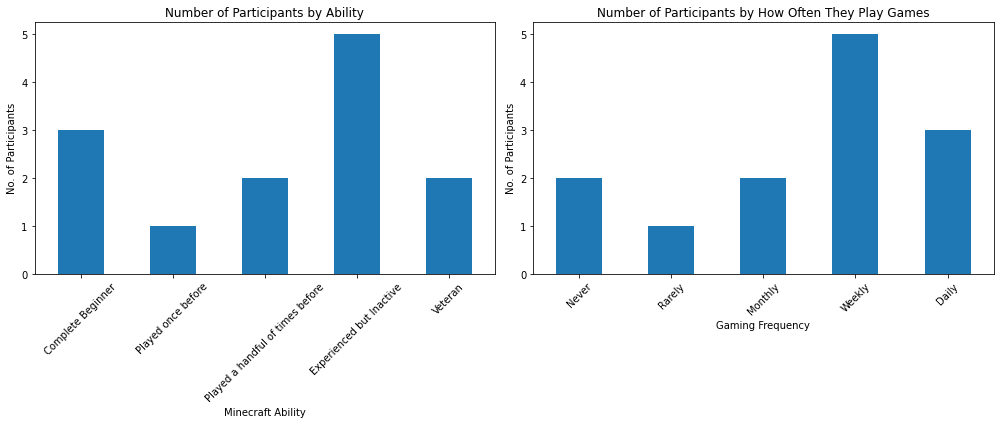

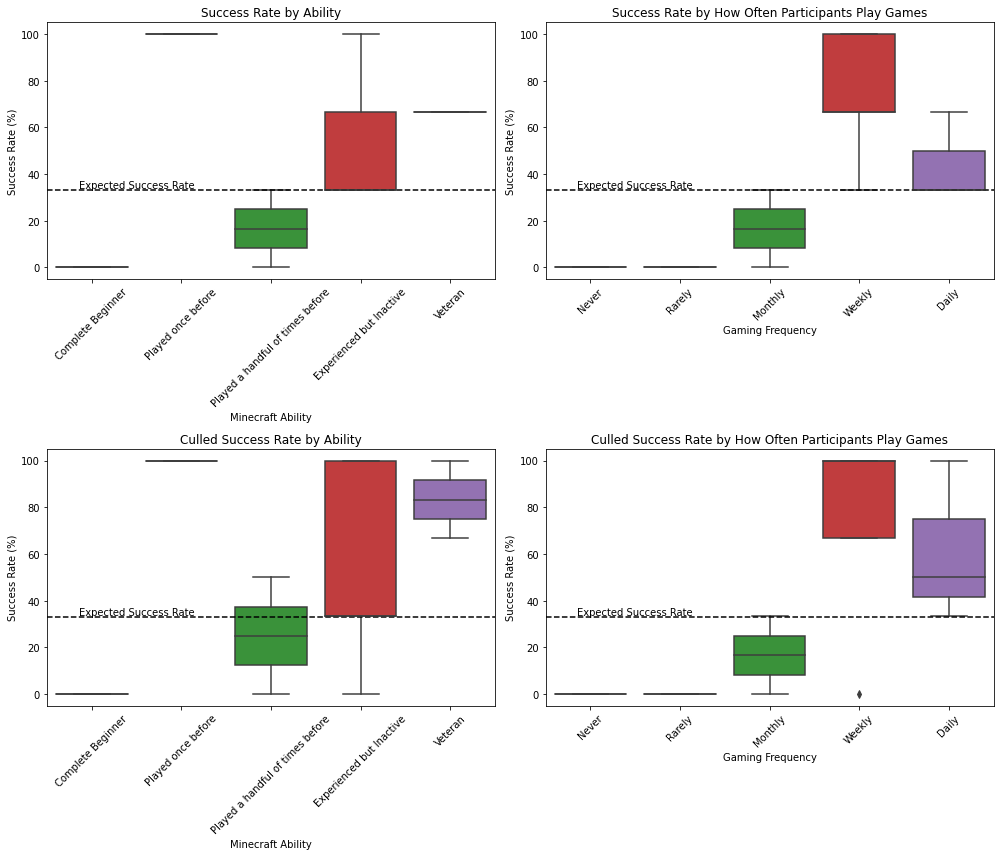

In [10]:
# First figure with the top two plots
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of number of participants by ability, ordered by experience level
df['ability'].value_counts().loc[['Complete Beginner', 'Played once before', 'Played a handful of times before', 'Experienced but Inactive', 'Veteran']].plot(kind='bar', ax=axes1[0], title='Number of Participants by Ability')
axes1[0].set_xlabel('Minecraft Ability')
axes1[0].set_ylabel('No. of Participants')
axes1[0].tick_params(axis='x', rotation=45)

# Bar chart of number of participants by how often they play games, ordered by frequency
df['how_often'].value_counts().loc[['Never', 'Rarely', 'Monthly', 'Weekly', 'Daily']].plot(kind='bar', ax=axes1[1], title='Number of Participants by How Often They Play Games')
axes1[1].set_xlabel('Gaming Frequency')
axes1[1].set_ylabel('No. of Participants')
axes1[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Second figure with the remaining four plots
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 12))

# Boxplot of success rate by ability, ordered by experience level
sns.boxplot(x='ability', y='success_rate', data=df, order=['Complete Beginner', 'Played once before', 'Played a handful of times before', 'Experienced but Inactive', 'Veteran'], ax=axes2[0, 0])
axes2[0, 0].axhline(y=33, color='black', linestyle='--')  # Draw a dotted line at 33%
axes2[0, 0].text(x=0.5, y=34, s='Expected Success Rate', color='black', ha='center')  # Add text above the line
axes2[0, 0].set_title('Success Rate by Ability')
axes2[0, 0].set_xlabel('Minecraft Ability')
axes2[0, 0].set_ylabel('Success Rate (%)')
axes2[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels to avoid overlap

# Boxplot of success rate by how often participants play games, ordered by frequency
sns.boxplot(x='how_often', y='success_rate', data=df, order=['Never', 'Rarely', 'Monthly', 'Weekly', 'Daily'], ax=axes2[0, 1])
axes2[0, 1].axhline(y=33, color='black', linestyle='--')  # Draw a dotted line at 33%
axes2[0, 1].text(x=0.5, y=34, s='Expected Success Rate', color='black', ha='center')  # Add text above the line
axes2[0, 1].set_title('Success Rate by How Often Participants Play Games')
axes2[0, 1].set_xlabel('Gaming Frequency')
axes2[0, 1].set_ylabel('Success Rate (%)')
axes2[0, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels to avoid overlap

# Boxplots with the same data, but with culled success rate
sns.boxplot(x='ability', y='success_rate_culled', data=df, order=['Complete Beginner', 'Played once before', 'Played a handful of times before', 'Experienced but Inactive', 'Veteran'], ax=axes2[1, 0])
axes2[1, 0].axhline(y=33, color='black', linestyle='--')  # Draw a dotted line at 33%
axes2[1, 0].text(x=0.5, y=34, s='Expected Success Rate', color='black', ha='center')  # Add text above the line
axes2[1, 0].set_title('Culled Success Rate by Ability')
axes2[1, 0].set_xlabel('Minecraft Ability')
axes2[1, 0].set_ylabel('Success Rate (%)')
axes2[1, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels to avoid overlap

# Boxplot of success rate by how often participants play games, ordered by frequency
sns.boxplot(x='how_often', y='success_rate_culled', data=df, order=['Never', 'Rarely', 'Monthly', 'Weekly', 'Daily'], ax=axes2[1, 1])
axes2[1, 1].axhline(y=33, color='black', linestyle='--')  # Draw a dotted line at 33%
axes2[1, 1].text(x=0.5, y=34, s='Expected Success Rate', color='black', ha='center')  # Add text above the line
axes2[1, 1].set_title('Culled Success Rate by How Often Participants Play Games')
axes2[1, 1].set_xlabel('Gaming Frequency')
axes2[1, 1].set_ylabel('Success Rate (%)')
axes2[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels to avoid overlap

plt.tight_layout()
plt.show()

Average Total Enjoyment: 4.0
Top 4 Genres:
RPG: 7 participants
Adventure: 6 participants
Action: 6 participants
Casual: 6 participants


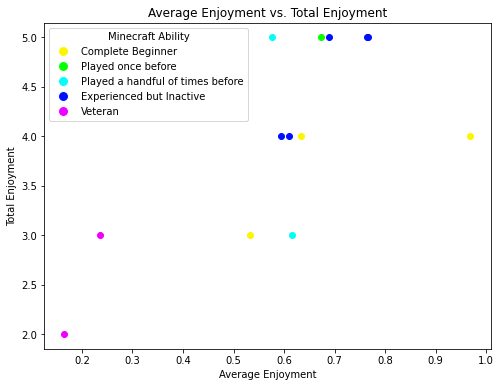

In [11]:
# Find the average total enjoyment
total_enjoyment_values = [participant.total_enjoyment for participant in participants.values()]
average_total_enjoyment = sum(total_enjoyment_values) / len(total_enjoyment_values)
print(f'Average Total Enjoyment: {average_total_enjoyment}')

# Find the most common genre(s) - the top 3 genres with their counts
genre_counts = {}
for participant in participants.values():
    for genre in participant.genres:
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:4]
print('Top 4 Genres:')
for genre, count in top_genres:
    print(f'{genre}: {count} participants')


# Plot scatter plot of average total enjoyment vs. the average of a participant's enjoyment values. 
# If enjoyment == '_': skip that value
average_enjoyment_values = []
for participant in participants.values():
    enjoyment_values = [float(value) for value in participant.enjoyment if value != '_']
    average_enjoyment = sum(enjoyment_values) / len(enjoyment_values) if enjoyment_values else 0
    average_enjoyment_values.append(average_enjoyment)

# Define a color map based on Minecraft ability levels
ability_levels = ['Complete Beginner', 'Played once before', 'Played a handful of times before', 'Experienced but Inactive', 'Veteran']
colors = sns.color_palette("hsv", len(ability_levels))
color_map = {level: colors[i] for i, level in enumerate(ability_levels)}

# Create a list of colors for each participant based on their ability level
participant_colors = [color_map[participant.ability] for participant in participants.values()]

plt.figure(figsize=(8, 6))
for i, participant in enumerate(participants.values()):
    plt.scatter(average_enjoyment_values[i], total_enjoyment_values[i], color=participant_colors[i], label=participant.ability)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[level], markersize=10, label=level) for level in ability_levels]
plt.legend(handles=handles, title='Minecraft Ability')

plt.xlabel('Average Enjoyment')
plt.ylabel('Total Enjoyment')
plt.title('Average Enjoyment vs. Total Enjoyment')
plt.show()

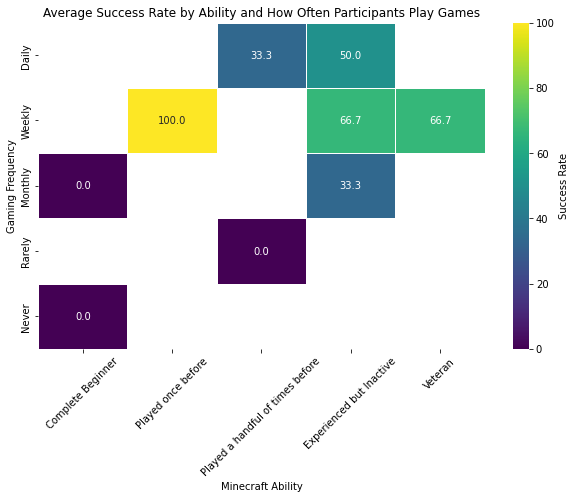

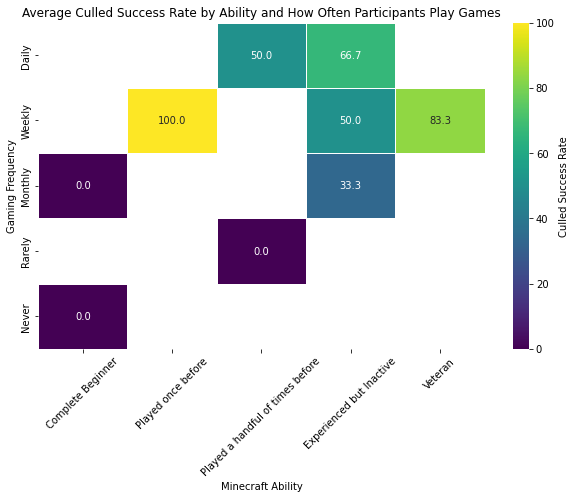

In [12]:
# Grid which is a heatmap-like matrix of the average success rate of participants based on their ability and how often they play games
# X-axis: Ability, Y-axis: How often they play games
# Color: Average success rate
# Ability order: Complete Beginner, Played once before, Played a handful of times before, Experienced but Inactive, Veteran
# How often order: Daily, Weekly, Monthly, Rarely, Never
# Use a pivot table to reshape the data for the heatmap
pivot_table = df.pivot_table(index='how_often', columns='ability', values='success_rate', aggfunc='mean', fill_value=np.nan)

# Reorder the rows and columns
pivot_table = pivot_table.loc[['Daily', 'Weekly', 'Monthly', 'Rarely', 'Never'], 
                              ['Complete Beginner', 'Played once before', 'Played a handful of times before', 'Experienced but Inactive', 'Veteran']]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Success Rate'}, mask=pivot_table.isnull())
plt.title('Average Success Rate by Ability and How Often Participants Play Games')
plt.xlabel('Minecraft Ability')
plt.ylabel('Gaming Frequency')
plt.tick_params(axis='x', rotation=45)
plt.show()

# Same but with culled success rate

# Use a pivot table to reshape the data for the heatmap
pivot_table_culled = df.pivot_table(index='how_often', columns='ability', values='success_rate_culled', aggfunc='mean', fill_value=np.nan)

# Reorder the rows and columns
pivot_table_culled = pivot_table_culled.loc[['Daily', 'Weekly', 'Monthly', 'Rarely', 'Never'], 
                              ['Complete Beginner', 'Played once before', 'Played a handful of times before', 'Experienced but Inactive', 'Veteran']]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_culled, cmap='viridis', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Culled Success Rate'}, mask=pivot_table_culled.isnull())
plt.title('Average Culled Success Rate by Ability and How Often Participants Play Games')
plt.xlabel('Minecraft Ability')
plt.ylabel('Gaming Frequency')
plt.tick_params(axis='x', rotation=45)
plt.show()


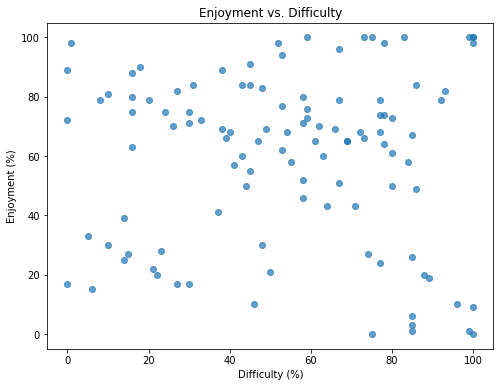

In [13]:
# Scatter plot of Enjoyment vs. Difficulty
enjoyment_values = []
difficulty_values = []
for participant in participants.values():
    for enjoyment, difficulty in zip(participant.enjoyment, participant.difficulty):
        if enjoyment != '_' and difficulty != '_':
            enjoyment_values.append(float(enjoyment) * 100)
            difficulty_values.append(float(difficulty) * 100)

plt.figure(figsize=(8, 6))
plt.scatter(difficulty_values, enjoyment_values, alpha=0.7)
plt.xlabel('Difficulty (%)')
plt.ylabel('Enjoyment (%)')
plt.title('Enjoyment vs. Difficulty')
plt.show()

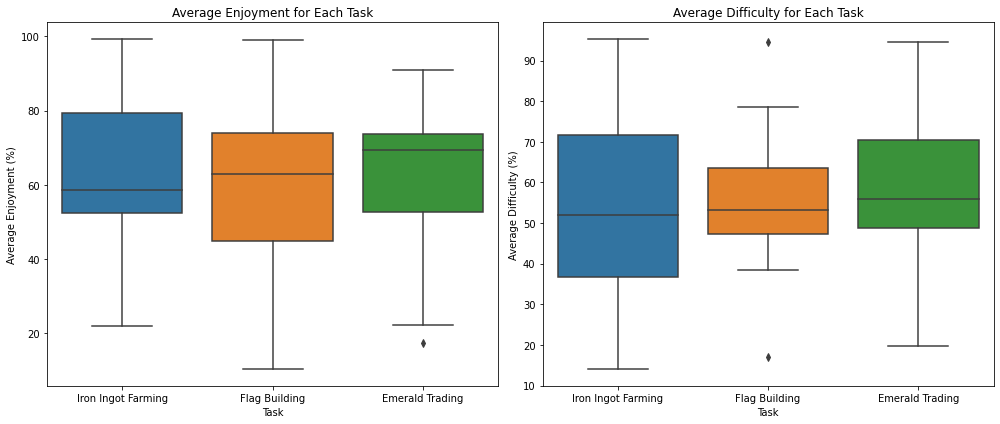

In [14]:
# Average enjoyment of each task. There is a task order, and for each task, there are normally three enjoyment values.
# Calculate the average enjoyment for each task.
task_names = ['Iron Ingot Farming', 'Flag Building', 'Emerald Trading']
task_enjoyment = {task: [] for task in task_names}
task_difficulty = {task: [] for task in task_names}

for participant in participants.values():
    for i, task in enumerate(task_names):
        enjoyment_values = [float(value) for value in participant.enjoyment[i::3] if value != '_']
        average_enjoyment = sum(enjoyment_values) / len(enjoyment_values) if enjoyment_values else 0
        task_enjoyment[task].append(average_enjoyment * 100)
        
        difficulty_values = [float(value) for value in participant.difficulty[i::3] if value != '_']
        average_difficulty = sum(difficulty_values) / len(difficulty_values) if difficulty_values else 0
        task_difficulty[task].append(average_difficulty * 100)

# Convert the task enjoyment and difficulty dictionaries to DataFrames
task_enjoyment_df = pd.DataFrame(task_enjoyment)
task_difficulty_df = pd.DataFrame(task_difficulty)

# Create a figure with two subplots for the boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot of the average enjoyment for each task
sns.boxplot(data=task_enjoyment_df, ax=axes[0])
axes[0].set_xlabel('Task')
axes[0].set_ylabel('Average Enjoyment (%)')
axes[0].set_title('Average Enjoyment for Each Task')

# Boxplot of the average difficulty for each task
sns.boxplot(data=task_difficulty_df, ax=axes[1])
axes[1].set_xlabel('Task')
axes[1].set_ylabel('Average Difficulty (%)')
axes[1].set_title('Average Difficulty for Each Task')

plt.tight_layout()
plt.show()

    Iron Ingot Farming  Flag Building  Emerald Trading
0                100.0            0.0              0.0
1                  0.0            0.0              0.0
2                100.0            0.0              0.0
3                  0.0            0.0              0.0
4                100.0          100.0              0.0
5                100.0          100.0              0.0
6                100.0          100.0              0.0
7                  0.0            0.0            100.0
8                  0.0          100.0            100.0
9                  0.0            0.0              0.0
10               100.0          100.0            100.0
11               100.0            0.0              0.0
12                 0.0            0.0              0.0


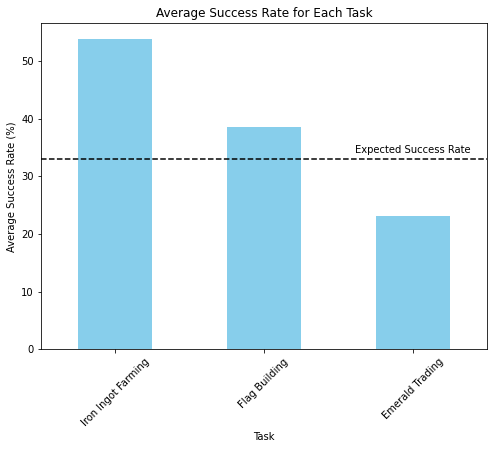

In [15]:
# Task vs Success Rate
# Calculate the average success rate for each task
task_success_rate = {task: [] for task in task_names}

for participant in participants.values():
    for i, task in enumerate(task_names):
        correct_matches = sum(1 for true, chosen, sureness in zip(participant.true_odd_ones[i::3], participant.chosen_odd_ones[i::3], participant.sureness[i::3]) if true == chosen and (sureness != '_' and sureness != '?'))
        total_odd_ones = sum(1 for sureness in participant.sureness[i::3] if sureness != '_' and sureness != '?')
        
        success_rate = (correct_matches / total_odd_ones) * 100 if total_odd_ones > 0 else 0
        task_success_rate[task].append(success_rate)

# Convert the task success rate dictionary to a DataFrame
task_success_rate_df = pd.DataFrame(task_success_rate)
print(task_success_rate_df)

# Create a bar plot of the average success rate for each task
task_success_rate_df.mean().plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.xlabel('Task')
plt.xticks(rotation=45)
plt.ylabel('Average Success Rate (%)')
plt.title('Average Success Rate for Each Task')
plt.axhline(y=33, color='black', linestyle='--')  # Draw a dotted line at 33%
plt.text(x=2, y=34, s='Expected Success Rate', color='black', ha='center')  # Add text above the line
plt.show()

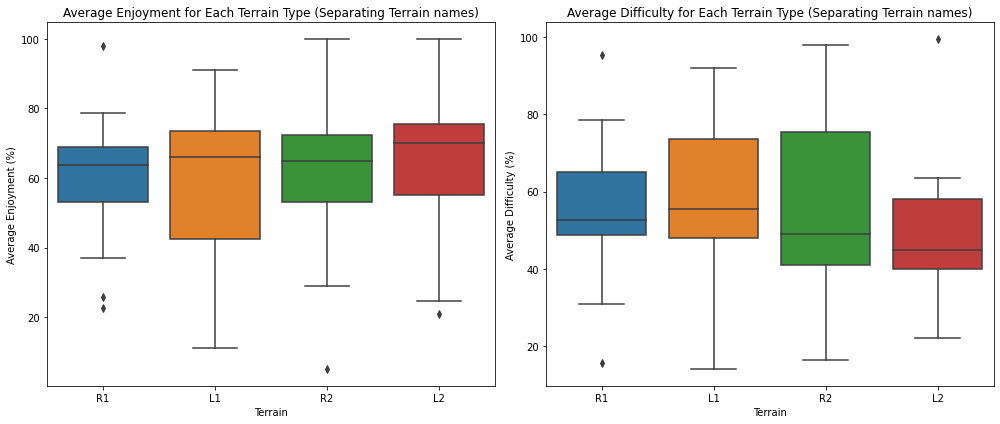

In [16]:
# Average enjoyment of each terrain type. There is a terrain order, and for each terrain, there is normally one enjoyment value.
# Calculate the average enjoyment for each terrain type.
terrain_names = ['R1', 'L1', 'R2', 'L2']
terrain_enjoyment = {terrain: [] for terrain in terrain_names}
terrain_difficulty = {terrain: [] for terrain in terrain_names}

for participant in participants.values():
    for i, terrain in enumerate(terrain_names):
        enjoyment_values = [float(value) for value in participant.enjoyment[i::4] if value != '_']
        average_enjoyment = sum(enjoyment_values) / len(enjoyment_values) if enjoyment_values else 0
        terrain_enjoyment[terrain].append(average_enjoyment * 100)  # Convert to percentage
        
        difficulty_values = [float(value) for value in participant.difficulty[i::4] if value != '_']
        average_difficulty = sum(difficulty_values) / len(difficulty_values) if difficulty_values else 0
        terrain_difficulty[terrain].append(average_difficulty * 100)  # Convert to percentage

# Convert the terrain enjoyment and difficulty dictionaries to DataFrames
terrain_enjoyment_df = pd.DataFrame(terrain_enjoyment)
terrain_difficulty_df = pd.DataFrame(terrain_difficulty)

# Create a figure with two subplots for the boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot of the average enjoyment for each terrain type
sns.boxplot(data=terrain_enjoyment_df, ax=axes[0])
axes[0].set_xlabel('Terrain')
axes[0].set_ylabel('Average Enjoyment (%)')
axes[0].set_title('Average Enjoyment for Each Terrain Type (Separating Terrain names)')

# Boxplot of the average difficulty for each terrain type
sns.boxplot(data=terrain_difficulty_df, ax=axes[1])
axes[1].set_xlabel('Terrain')
axes[1].set_ylabel('Average Difficulty (%)')
axes[1].set_title('Average Difficulty for Each Terrain Type (Separating Terrain names)')

plt.tight_layout()
plt.show()

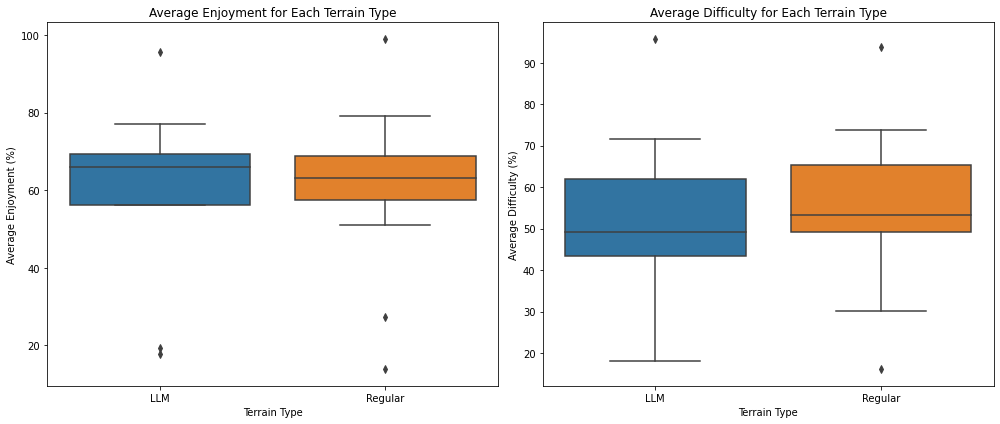

In [17]:
# Mean and standard deviation of average enjoyment for each terrain type (combining L1 and L2, R1 and R2)
terrain_enjoyment_df['LLM'] = terrain_enjoyment_df[['L1', 'L2']].mean(axis=1)
terrain_enjoyment_df['Regular'] = terrain_enjoyment_df[['R1', 'R2']].mean(axis=1)

# Mean and standard deviation of average difficulty for each terrain type (combining L1 and L2, R1 and R2)
terrain_difficulty_df['LLM'] = terrain_difficulty_df[['L1', 'L2']].mean(axis=1)
terrain_difficulty_df['Regular'] = terrain_difficulty_df[['R1', 'R2']].mean(axis=1)

# Combining L1 and L2, R1 and R2
terrain_enjoyment_df['LLM'] = terrain_enjoyment_df[['L1', 'L2']].mean(axis=1)
terrain_enjoyment_df['Regular'] = terrain_enjoyment_df[['R1', 'R2']].mean(axis=1)
terrain_difficulty_df['LLM'] = terrain_difficulty_df[['L1', 'L2']].mean(axis=1)
terrain_difficulty_df['Regular'] = terrain_difficulty_df[['R1', 'R2']].mean(axis=1)

# Create a figure with two subplots for the boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot of the average enjoyment for each terrain type
sns.boxplot(data=terrain_enjoyment_df[['LLM', 'Regular']], ax=axes[0])
axes[0].set_xlabel('Terrain Type')
axes[0].set_ylabel('Average Enjoyment (%)')
axes[0].set_title('Average Enjoyment for Each Terrain Type')

# Boxplot of the average difficulty for each terrain type
sns.boxplot(data=terrain_difficulty_df[['LLM', 'Regular']], ax=axes[1])
axes[1].set_xlabel('Terrain Type')
axes[1].set_ylabel('Average Difficulty (%)')
axes[1].set_title('Average Difficulty for Each Terrain Type')

plt.tight_layout()
plt.show()

In [18]:
# Calculate the average scores of enjoyment and difficulty for each participant
average_enjoyment_scores = []
average_difficulty_scores = []

for participant in participants.values():
    enjoyment_values = [float(value) for value in participant.enjoyment if value != '_']
    difficulty_values = [float(value) for value in participant.difficulty if value != '_']
    
    average_enjoyment = sum(enjoyment_values) / len(enjoyment_values) if enjoyment_values else 0
    average_difficulty = sum(difficulty_values) / len(difficulty_values) if difficulty_values else 0
    
    average_enjoyment_scores.append(average_enjoyment)
    average_difficulty_scores.append(average_difficulty)

# Calculate the overall average enjoyment and difficulty scores
overall_average_enjoyment = sum(average_enjoyment_scores) / len(average_enjoyment_scores)
overall_average_difficulty = sum(average_difficulty_scores) / len(average_difficulty_scores)

print(f'Overall Average Enjoyment: {overall_average_enjoyment}')
print(f'Overall Average Difficulty: {overall_average_difficulty}')

Overall Average Enjoyment: 0.6018986568986568
Overall Average Difficulty: 0.5496214896214896
